In [1]:
import torch
import lightning.pytorch as pl
from skimage.metrics import peak_signal_noise_ratio
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

from src.forward_operator.operators import cfa_operator
from src.lightning_classes import UnrolledSystem, DataModule
from src.data_loader import RGBDataset

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CFAS = ['bayer', 'sony', 'quad_bayer', 'kodak']
TRAIN_DIR = 'images/train'
VAL_DIR = 'images/val'
TEST_DIR = 'images/test'
PATCH_SIZE = 32
BATCH_SIZE = 512

In [3]:
train_dataset = RGBDataset(TRAIN_DIR, CFAS, PATCH_SIZE, PATCH_SIZE // 2)
val_dataset = RGBDataset(VAL_DIR, CFAS, PATCH_SIZE, PATCH_SIZE)
test_dataset = RGBDataset(TEST_DIR, CFAS, PATCH_SIZE, PATCH_SIZE)
data_module = DataModule(train_dataset, val_dataset, test_dataset, BATCH_SIZE)

version = 'all'
model = UnrolledSystem.load_from_checkpoint(f'lightning_logs/{version}/checkpoints/best.ckpt')

trainer = pl.Trainer()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/mullemat/.venv/torch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [4]:
trainer.test(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 118/118 [00:44<00:00,  2.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss/Test          0.0007464925292879343
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Loss/Test': 0.0007464925292879343}]

In [5]:
def prepare_input(path, cfas):
    x = imread(path) / 255
    inputs = []

    for cfa in cfas:
        op = cfa_operator(cfa, x.shape, [650, 525, 480], 'dirac')
        y = torch.Tensor(op.direct(x))[None]
        mask = torch.Tensor(op.cfa_mask).permute(2, 0, 1)
        inputs.append(torch.cat([y, mask]))

    return x, torch.stack(inputs)

In [6]:
path = 'images/test/28083.jpg'
x, input_data = prepare_input(path, CFAS)

model.eval()
with torch.no_grad():
    x_hat_list = np.clip(torch.stack(model(input_data)).permute(1, 0, 3, 4, 2).numpy(force=True).astype(float), 0, 1)

In [7]:
x = x[2:-2, 2:-2]
x_hat_list = x_hat_list[:, :, 2:-2, 2:-2]

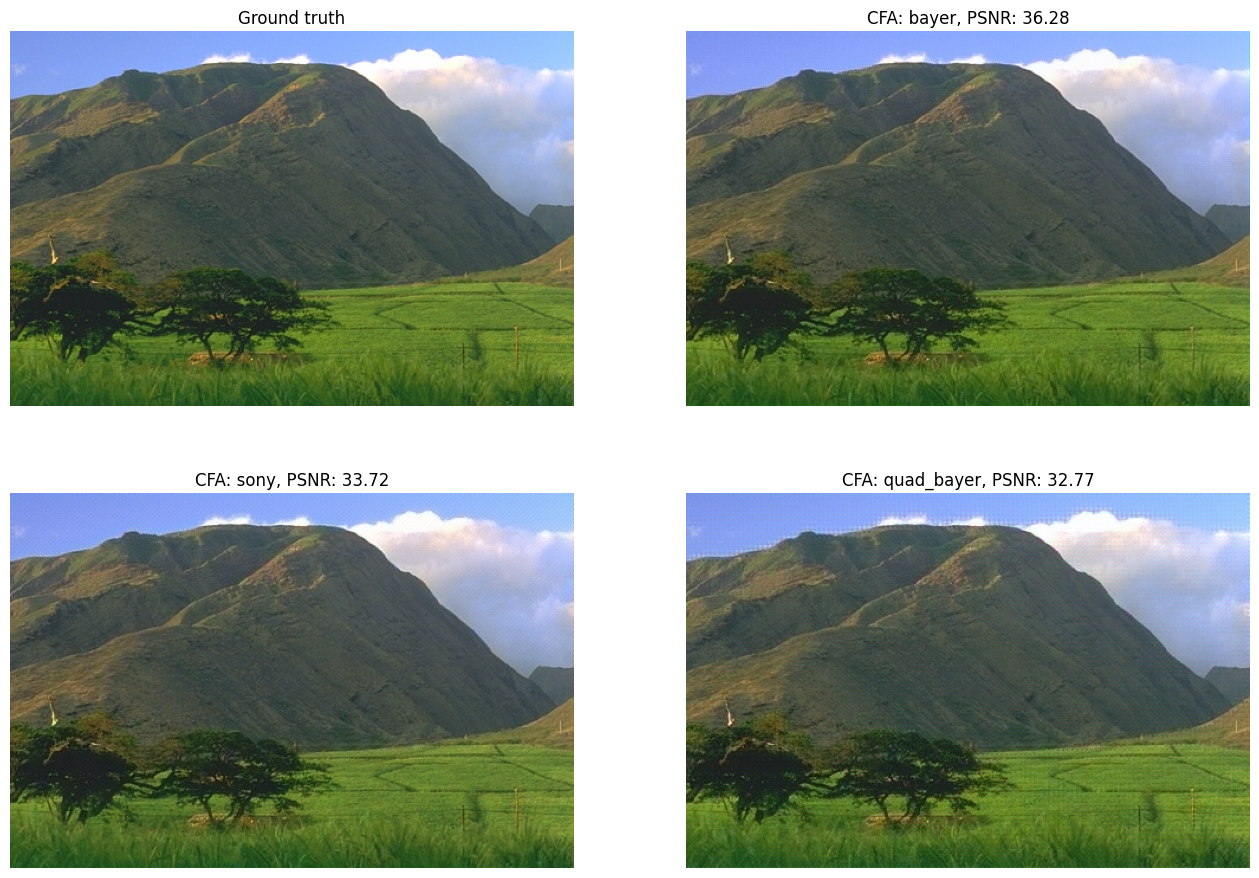

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(16, 11))
iter = -1

axs[0, 0].imshow(x)
axs[0, 0].set_title('Ground truth')
axs[0, 0].axis('off')
axs[0, 1].imshow(x_hat_list[0, iter])
axs[0, 1].set_title(f'CFA: {CFAS[0]}, PSNR: {peak_signal_noise_ratio(x, x_hat_list[0, iter]):.2f}')
axs[0, 1].axis('off')
axs[1, 0].imshow(x_hat_list[1, iter])
axs[1, 0].set_title(f'CFA: {CFAS[1]}, PSNR: {peak_signal_noise_ratio(x, x_hat_list[1, iter]):.2f}')
axs[1, 0].axis('off')
axs[1, 1].imshow(x_hat_list[2, iter])
axs[1, 1].set_title(f'CFA: {CFAS[2]}, PSNR: {peak_signal_noise_ratio(x, x_hat_list[2, iter]):.2f}')
axs[1, 1].axis('off')
plt.show()

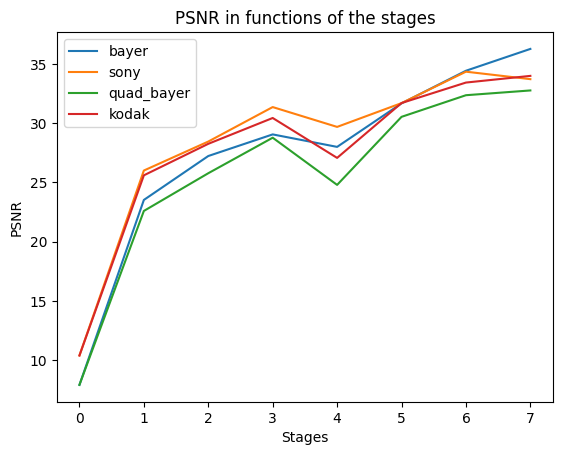

In [9]:
for i in range(len(CFAS)):
    plt.plot([peak_signal_noise_ratio(x, x_hat) for x_hat in x_hat_list[i]], label=CFAS[i])

plt.title('PSNR in functions of the stages')
plt.xlabel('Stages')
plt.ylabel('PSNR')
plt.legend()
plt.show()